In [1]:
import numpy as np
import torch
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
from pathlib import Path
import h5py

# 1) block 'blood-oxygen' 
cur = Path.cwd()
bo_root = next(p for p in [cur, *cur.parents] if p.name == "blood-oxygen")

# 2) into spo2-phonecam (subsystem of author)
spo2_root = bo_root / "spo2-phonecam"

# 3) (form the pathway of data.h5)
H5 = (spo2_root / "external/oximetry-phone-cam-data/data/preprocessed/all_uw_data.h5").resolve()
print("Using:", H5)
assert H5.exists(), f"not exist：{H5}"

# 4) read
with h5py.File(H5, "r") as f:
    print("Keys:", list(f.keys()))
    data = f["dataset"][:]
    gt   = f["groundtruth"][:]
print(data.shape, gt.shape)


Using: /Users/katyhuang/Desktop/blood-oxygen/spo2-phonecam/external/oximetry-phone-cam-data/data/preprocessed/all_uw_data.h5
Keys: ['dataset', 'groundtruth']
(6, 6, 33660) (6, 5, 1122)


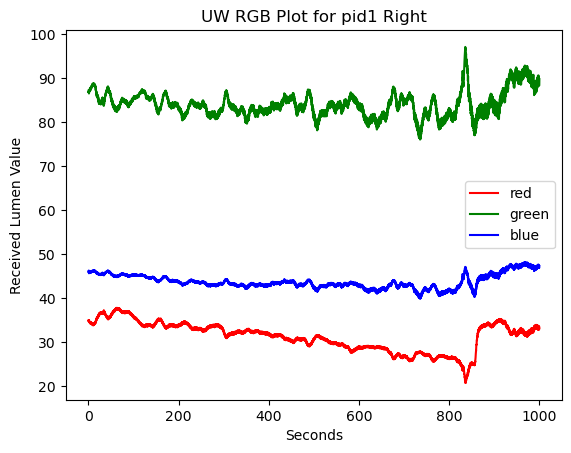

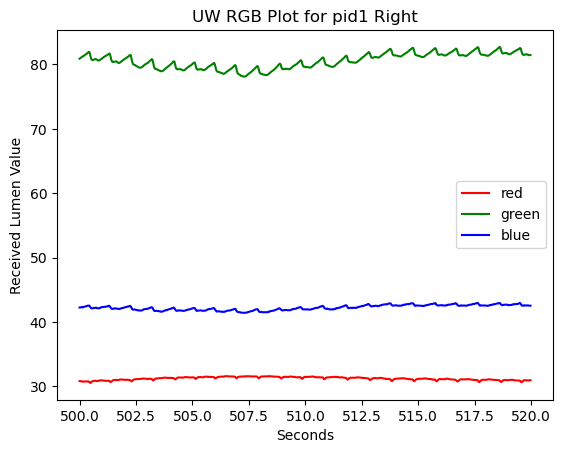

In [6]:
# Plot the red, green, and blue chanel in the time range. Choose either left or right hand.
def plot_RGB(data, pid=0, left=True, sec_from=0, sec_to=1000):
    title = "pid" + str(pid+1)
    X = np.arange(sec_from, sec_to, 1/30)
    if left:
        plt.plot(X, data[pid, 0, sec_from*30:sec_to*30], label="red", color="red")
        plt.plot(X, data[pid, 1, sec_from*30:sec_to*30], label="green", color="green")
        plt.plot(X, data[pid, 2, sec_from*30:sec_to*30], label="blue", color="blue")
        title += " Left"
    else:
        plt.plot(X, data[pid, 3, sec_from*30:sec_to*30], label="red", color="red")
        plt.plot(X, data[pid, 4, sec_from*30:sec_to*30], label="green", color="green")
        plt.plot(X, data[pid, 5, sec_from*30:sec_to*30], label="blue", color="blue")
        title += " Right"
    plt.title("UW RGB Plot for " + title)
    plt.legend()
    plt.xlabel("Seconds")
#     plt.ylim(0, 250)
    plt.ylabel("Received Lumen Value")
    plt.show()
    
plot_RGB(data, pid=0, left=False, sec_from=0, sec_to=1000)
plot_RGB(data, pid=0, left=False, sec_from=500, sec_to=520)

In [7]:
# Make a list of data points for visualizing or training
def make_temp_data(data_uw, groundtruth_uw, data_idx=[], gt_ind = 3):
    # Select 0th sample, right hand
    res_data_list = []
    res_gt_list = []
    for pid, row in enumerate(data_idx):
        if row[0] == 1:
            res_data_list.append(data_uw[pid][:3,:])
            res_gt_list.append(groundtruth_uw[pid][gt_ind,:])
        if row[1] == 1:
            res_data_list.append(data_uw[pid][3:,:]) 
            res_gt_list.append(groundtruth_uw[pid][gt_ind, :])

    results_data_list = []
    results_gt_list = []
    fps_list = []
    for i in range(len(res_gt_list)):
        # find zeros
        zeros_data = np.where(res_data_list[i][0] == 0)[0]
        zeros_gt = np.where(res_gt_list[i] == 0)[0]

        if len(zeros_data) > 0:
            result_data_i = res_data_list[i][:, :int(zeros_data[0])]
        else:
            result_data_i = res_data_list[i]
        if len(zeros_gt) > 0:
            result_gt_i = res_gt_list[i][:int(zeros_gt[0])]
        else:
            result_gt_i = res_gt_list[i]

        # Calculate shorter and clip
        fps = 30
        clip_len = min(result_gt_i.shape[0], result_data_i.shape[1] // fps)
        result_data_i = result_data_i[:, :clip_len*fps]
        result_gt_i = result_gt_i[:clip_len]

        results_gt_list.append(result_gt_i)
        results_data_list.append(result_data_i)
        fps_list.append(fps)

    return {"data": results_data_list, "gt": results_gt_list, "fps": fps_list}

UW: mean=87.220673, std=9.325543


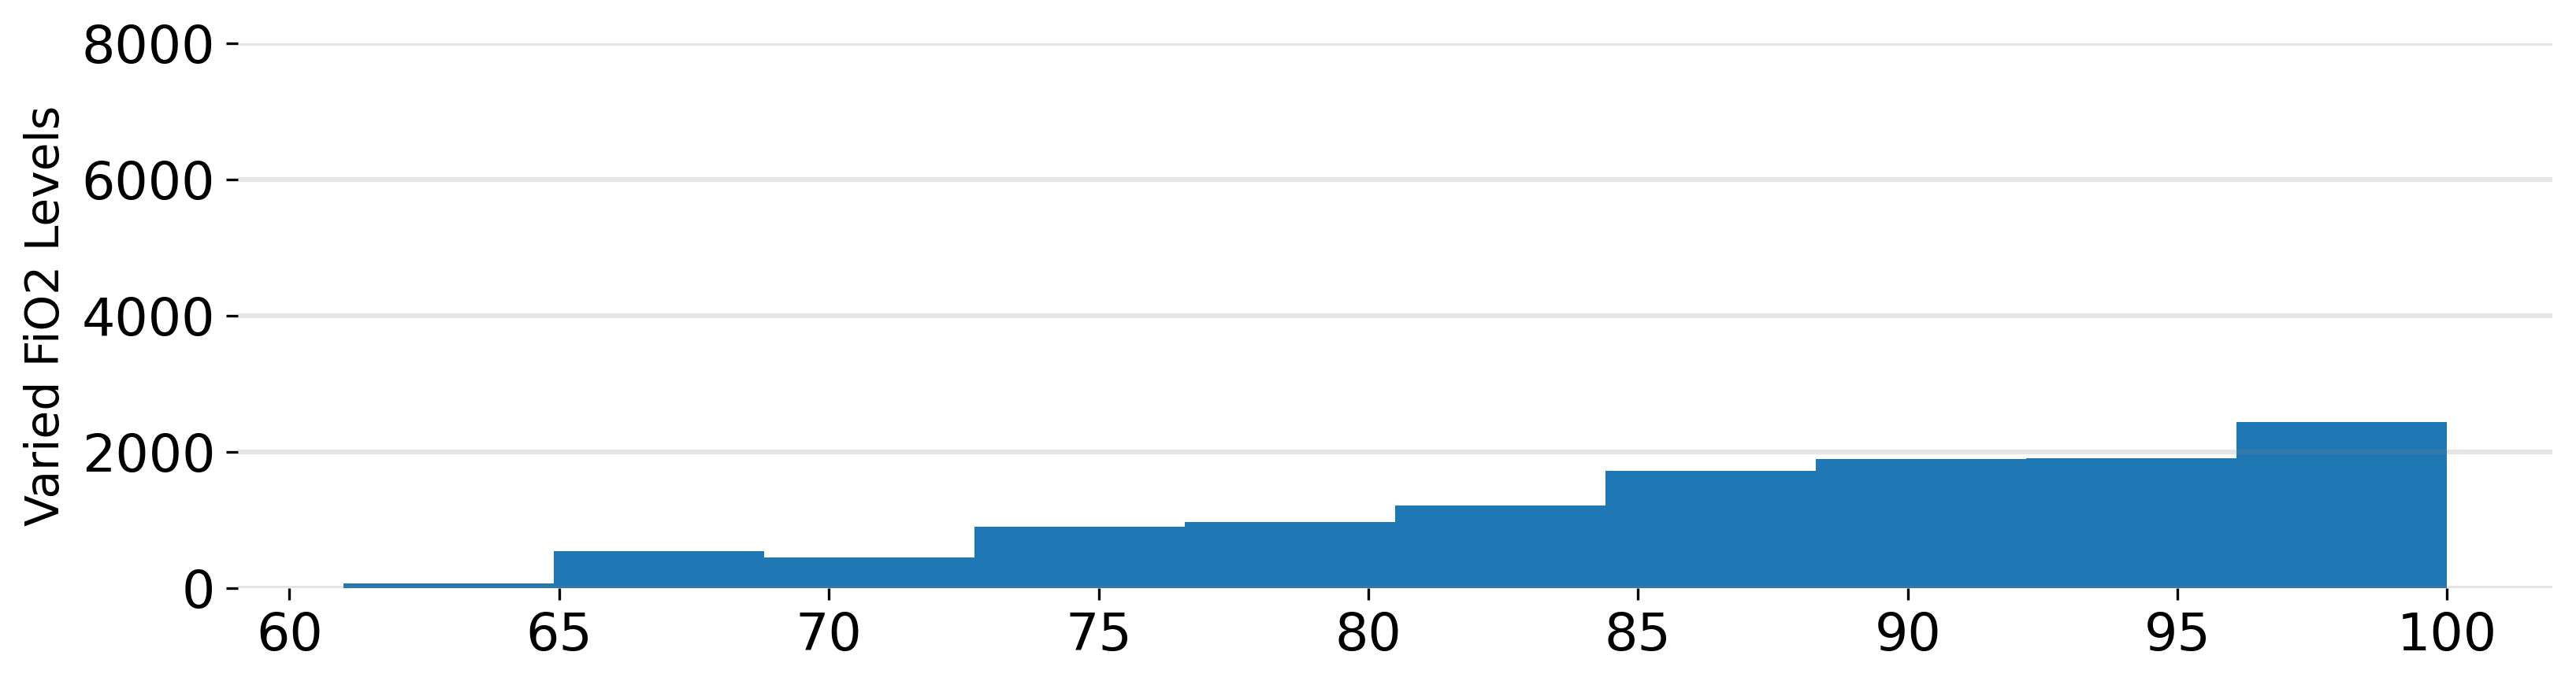

In [5]:
# Plot a historgram of the data distribution
def hist_UW():
    all_data_idx = np.ones((6,2))
    all_seq = make_temp_data(data, groundtruth, gt_ind=3, data_idx=all_data_idx)
    gtdatapoints = []
    for seq in all_seq["gt"]:
        gtdatapoints.extend(seq)
    gtdatapoints = np.array(gtdatapoints)
    print('UW: mean=%f, std=%f' % \
          (np.mean(gtdatapoints),np.std(gtdatapoints)))
    plt.figure(figsize=(11,3),dpi=300)
    plt.hist(gtdatapoints,bins=10, )
    ax = plt.gca()

    ax.set_ylim(top=8000)

    locs = ax.yaxis.get_ticklocs()
    labs = ax.yaxis.get_ticklabels()
    # print([lab.get_text() for lab in ax.yaxis.get_ticklabels()])
    new_locs = []
    new_labs = []
    for i, (loc, lab) in enumerate(list(zip(locs, labs))):
        if (i) % 2 == 0:
            # if i == 0:
            #     continue
            new_locs.append(loc)
            new_labs.append(lab)
            plt.axhline(y=loc, color="grey", alpha=0.2)

    ax.set_yticks(new_locs)
    ax.set_yticklabels(["0", "2000", "4000", "6000", "8000"], fontsize=16)

    # ax.set_xticks(ax.get_xticks(), fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=16)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

    ax.set_ylabel("Varied FiO2 Levels", fontsize=14)
    plt.tight_layout()

hist_UW()

In [12]:
import os
print(os.path.exists(f'{PATH}/../gt/metadata.csv'))   # True 才是对的


False


In [13]:

#location of the author folder 
PATH = '../spo2-phonecam/external/oximetry-phone-cam-data/data/preprocessed'  # 字符串

def load_metadata(metapath):
    import pandas as pd
    return pd.read_csv(metapath)

# View metadata descriptions
meta_df = load_metadata(metapath=f'{PATH}/../gt/metadata.csv')
print(meta_df.shape)


(44, 3)


In [14]:
# View metadata descriptions
def load_metadata(metapath):
    meta_df = pd.read_csv(metapath)
#     print()
    return meta_df

load_metadata(metapath=f'{PATH}//..//gt/metadata.csv')

,Label,Description,Unit
0,SpO2 1,SpO2 reading from PPG of pulse ox 1 (3900P TT+...,Percentage
1,SpO2 2,SpO2 reading from PPG of pulse ox 2 (Nellcor N...,Percentage
2,SpO2 3,Unfilled signal from pulse ox 3 (Safety Oxim 3...,Unknown
3,SpO2 4,SpO2 reading from PPG of pulse ox 4 (Nellcor N...,Percentage
4,SpO2 5,SpO2 reading from PPG of pulse ox 5 (Masimo Ra...,Percentage
5,Pulse 1,Heart rate from PPG of pulse ox 1 (3900P TT+ 9...,bpm
6,Pulse 2,Heart rate from PPG of pulse ox 2 (Nellcor N-6...,bpm
7,Pulse 3,Unfilled signal from pulse ox 3 (Safety Oxim 3...,Unknown
8,Pulse 4,Heart rate from PPG of pulse ox 4 (Nellcor N-6...,bpm
9,Pulse 5,Heart rate from PPG of pulse ox 5 (Masimo Radi...,bpm


In [30]:
# === Auto-pick DEVICE_IDX by quick LOSO ===
import numpy as np

D = groundtruth.shape[1]
print(f"devices in groundtruth: {D}")

#  look at the basic distribution of y in each column (only within the range of 70 to 100)）
for di in range(D):
    y_all = groundtruth[:, di, :].ravel()
    m = (y_all >= 70) & (y_all <= 100) & ~np.isnan(y_all)
    if m.any():
        print(f"[di={di}] n={int(m.sum())}  min/median/max = "
              f"{float(np.nanmin(y_all[m])):.1f}/"
              f"{float(np.nanmedian(y_all[m])):.1f}/"
              f"{float(np.nanmax(y_all[m])):.1f}")
    else:
        print(f"[di={di}] no valid labels in 70–100")

# Conduct a "quick test" with fewer rounds to select the best device_idx
def quick_loso_mae(di, epochs=40):
    X_L, y, owners  = make_windows_filtered_v2(data, groundtruth, use_left=True,  device_idx=di)
    X_R, y2, owners2 = make_windows_filtered_v2(data, groundtruth, use_left=False, device_idx=di)
    assert np.array_equal(y, y2) and np.array_equal(owners, owners2), "左右手的 y/owners 不一致，检查 data/gt 对齐"
    X6 = np.concatenate([X_L, X_R], axis=1).astype("float32")
    yt, yp, per = run_loso_generic(
        X6, y, owners,
        model_factory=lambda in_ch: Shallow1DCNN(in_ch),
        epochs=epochs, base_lr=3e-4, wd=5e-4, bs=256, patience=10, low_weight=5.0
    )
    return float(np.mean([r["mae"] for r in per]))

scores = []
for di in range(D):
    try:
        mae = quick_loso_mae(di, epochs=40)
        scores.append((mae, di))
        print(f"[quick] device_idx={di}  mean MAE={mae:.3f}%")
    except Exception as e:
        print(f"[quick] device_idx={di} FAILED -> {e}")

best_mae, best_idx = sorted(scores)[0]
print(f"\n>>> Auto-picked DEVICE_IDX = {best_idx}  (mean MAE={best_mae:.3f}%)")
DEVICE_IDX = best_idx  # Set to global for reuse in the next cell


devices in groundtruth: 5
[di=0] n=5832  min/median/max = 70.0/89.7/100.0
[di=1] n=5962  min/median/max = 70.0/90.0/100.0
[di=2] no valid labels in 70–100
[di=3] n=5714  min/median/max = 70.0/89.5/100.0
[di=4] n=5802  min/median/max = 70.0/90.0/100.0
[v2] X: (5819, 3, 90) y: (5819,) subjects: [0 1 2 3 4 5]
[v2] X: (5819, 3, 90) y: (5819,) subjects: [0 1 2 3 4 5]
device: mps
[LOSO] held=0  test MAE=21.787%  n=972
[LOSO] held=1  test MAE=6.196%  n=1119
[LOSO] held=2  test MAE=10.736%  n=1031
[LOSO] held=3  test MAE=5.474%  n=1013
[LOSO] held=4  test MAE=6.639%  n=892
[LOSO] held=5  test MAE=6.720%  n=792
[quick] device_idx=0  mean MAE=9.592%
[v2] X: (5949, 3, 90) y: (5949,) subjects: [0 1 2 3 4 5]
[v2] X: (5949, 3, 90) y: (5949,) subjects: [0 1 2 3 4 5]
device: mps
[LOSO] held=0  test MAE=22.766%  n=1088
[LOSO] held=1  test MAE=8.882%  n=1119
[LOSO] held=2  test MAE=8.164%  n=1038
[LOSO] held=3  test MAE=5.881%  n=1013
[LOSO] held=4  test MAE=7.604%  n=907
[LOSO] held=5  test MAE=7.500% 

[v2] X: (5701, 3, 90) y: (5701,) subjects: [0 1 2 3 4 5]
[v2] X: (5701, 3, 90) y: (5701,) subjects: [0 1 2 3 4 5]
X6: (5701, 6, 90) y: (5701,)
device: mps
[LOSO] held=0  test MAE=23.099%  n=968
[LOSO] held=1  test MAE=10.117%  n=1119
[LOSO] held=2  test MAE=7.122%  n=1026
[LOSO] held=3  test MAE=4.660%  n=1013
[LOSO] held=4  test MAE=7.104%  n=855
[LOSO] held=5  test MAE=6.091%  n=720
LOSO mean MAE = 9.69910979270935
MAE=9.853%  RMSE(Arms)=13.288%  R2=-1.685
MAE 70-80% = 7.654627323150635 (n=1123)
MAE 80-90% = 6.059839725494385 (n=2110)
MAE 90-100% = 13.086028099060059 (n=2844)
Thr<92%  Sens=0.951  Spec=0.108  (pos=3317, neg=2384)
Thr<90%  Sens=0.897  Spec=0.164  (pos=2857, neg=2844)
Thr<88%  Sens=0.864  Spec=0.275  (pos=2325, neg=3376)


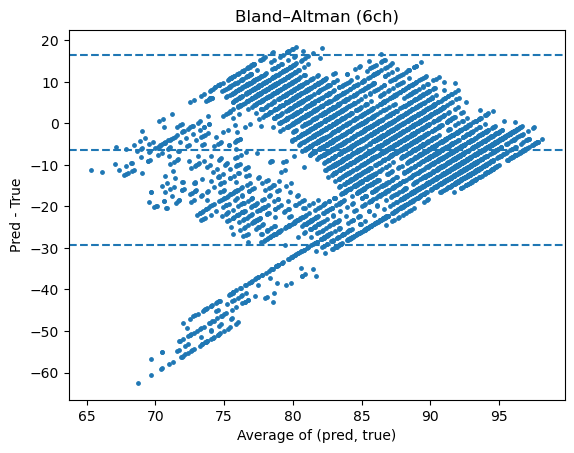

In [31]:
# === Re-run with the picked DEVICE_IDX ===

# 1) Reconstruct the 6-channel sample
X_L, y, owners  = make_windows_filtered_v2(data, groundtruth, use_left=True,  device_idx=DEVICE_IDX)
X_R, y2, owners2 = make_windows_filtered_v2(data, groundtruth, use_left=False, device_idx=DEVICE_IDX)
assert np.array_equal(y, y2) and np.array_equal(owners, owners2)
X6 = np.concatenate([X_L, X_R], axis=1).astype("float32")
print("X6:", X6.shape, "y:", y.shape)

# 2) Formal LOSO training (the number of rounds has been restored to 160

y_true6, y_pred6, per6 = run_loso_generic(
    X6, y, owners,
    model_factory=lambda in_ch: Shallow1DCNN(in_ch),
    epochs=160, base_lr=3e-4, wd=5e-4, bs=256, patience=25, low_weight=5.0
)
print("LOSO mean MAE =", np.mean([r['mae'] for r in per6]))

# 3) Evaluation (the same as before)
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt
yt, yp = y_true6, y_pred6
mae  = float(mean_absolute_error(yt, yp))
rmse = float(np.sqrt(np.mean((yt - yp)**2)))
r2   = float(r2_score(yt, yp))
print(f"MAE={mae:.3f}%  RMSE(Arms)={rmse:.3f}%  R2={r2:.3f}")
for lo, hi in [(70,80),(80,90),(90,100)]:
    m = (yt>=lo)&(yt<=hi)
    if m.any():
        print(f"MAE {lo}-{hi}% =", float(mean_absolute_error(yt[m], yp[m])), f"(n={m.sum()})")

def sens_spec(y_true, y_pred, thr):
    yb = (y_true < thr).astype(int); pb = (y_pred < thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(yb, pb, labels=[0,1]).ravel()
    return tp/(tp+fn+1e-8), tn/(tn+fp+1e-8), int(tp+fn), int(tn+fp)

for thr in [92.0, 90.0, 88.0]:
    s, p, pos_n, neg_n = sens_spec(yt, yp, thr)
    print(f"Thr<{thr:.0f}%  Sens={s:.3f}  Spec={p:.3f}  (pos={pos_n}, neg={neg_n})")

diff = yp - yt; avg = 0.5*(yp + yt)
md, sd = diff.mean(), diff.std()
plt.figure(); plt.scatter(avg, diff, s=6)
plt.axhline(md, ls='--'); plt.axhline(md+1.96*sd, ls='--'); plt.axhline(md-1.96*sd, ls='--')
plt.xlabel("Average of (pred, true)"); plt.ylabel("Pred - True"); plt.title("Bland–Altman (6ch)"); plt.show()


In [33]:
# v3: v2 AC/DC quality Control (Default threshold 0.02)
import numpy as np
from scipy import signal
from scipy.signal import medfilt

def _acdc_score(window):  # window: (3, win) —— original value
    ac = np.percentile(window, 95, axis=1) - np.percentile(window, 5, axis=1)
    dc = np.maximum(window.mean(axis=1), 1e-6)
    acdc = ac / dc
    return float(acdc.max())  # Take the largest AC/DC among the three channels of this hand

def make_windows_filtered_v3(data, groundtruth, use_left=True, device_idx=0,
                             fps=30, win=90, band=(0.5, 8.0),
                             mean_frac_thr=0.20, per_ch_std_thr=1e-3,
                             acdc_thr=0.02, order=3, med_k=5):
    ch = slice(0,3) if use_left else slice(3,6)
    b, a = signal.butter(order, [band[0]/(fps/2), band[1]/(fps/2)], btype="band")

    subj_mean = np.stack([np.nanmean(data[i, ch, :], axis=1)
                          for i in range(data.shape[0])])  # (subjects, 3)

    Xs, ys, owners = [], [], []
    n_subj, _, n_frames = data.shape
    n_secs = groundtruth.shape[-1]

    for pid in range(n_subj):
        base_mean = np.maximum(subj_mean[pid], 1e-6)
        for sec in range(1, n_secs-1):
            c = sec*fps; s, e = c - win//2, c + win//2
            if s < 0 or e > n_frames: 
                continue
            y = float(groundtruth[pid, device_idx, sec])
            if not (70.0 <= y <= 100.0):
                continue

            x_raw = data[pid, ch, s:e]
            if x_raw.shape[-1] != win:
                continue

            # Quality Control 1: Low mean/low variance
            if np.any(x_raw.mean(axis=1) < mean_frac_thr*base_mean) or np.any(x_raw.std(axis=1) < per_ch_std_thr):
                continue
                
            # Quality Control 2: AC/DC (Pulse Intensity)
            if _acdc_score(x_raw) < acdc_thr:
                continue

            # Median bandpass z-score
        
            xf = np.zeros_like(x_raw, dtype=np.float32)
            for k in range(x_raw.shape[0]):
                tmp = signal.filtfilt(b, a, x_raw[k], method="pad")
                tmp = medfilt(tmp, kernel_size=med_k)
                m, sd = tmp.mean(), tmp.std() + 1e-8
                xf[k] = (tmp - m) / sd

            Xs.append(xf.astype(np.float32)); ys.append(y); owners.append(pid)

    X = np.stack(Xs).astype(np.float32)
    y = np.array(ys, np.float32)
    owners = np.array(owners, int)
    print("[v3] X:", X.shape, "y:", y.shape, "subjects:", np.unique(owners))
    return X, y, owners


In [34]:
# === Build 6 channels in pairs at one time (v3 AC/DC quality control) ===
import numpy as np
from scipy import signal
from scipy.signal import medfilt

def _acdc_score(win):  # win: (3, T) original value
    ac = np.percentile(win, 95, axis=1) - np.percentile(win, 5, axis=1)
    dc = np.maximum(win.mean(axis=1), 1e-6)
    return float((ac / dc).max())

def make_paired_windows_filtered_v3(
    data, groundtruth, device_idx=0, fps=30, win=90, band=(0.5, 8.0),
    mean_frac_thr=0.20, per_ch_std_thr=1e-3, acdc_thr=0.02, order=3, med_k=5
):
    """
    return：X6 (N, 6, win), y (N,), owners (N,)
    Both hands must pass the quality control simultaneously before the sample is accepted. Each sample corresponds to the same pid, sec。
    """
    L = slice(0,3); R = slice(3,6)
    b, a = signal.butter(order, [band[0]/(fps/2), band[1]/(fps/2)], btype="band")

    # channel mean at the subject level (calculated separately for left and right, used for relative thresholds)
    subj_mean_L = np.stack([np.nanmean(data[i, L, :], axis=1) for i in range(data.shape[0])])  # (S,3)
    subj_mean_R = np.stack([np.nanmean(data[i, R, :], axis=1) for i in range(data.shape[0])])  # (S,3)

    Xs, ys, owners = [], [], []
    n_subj, _, n_frames = data.shape
    n_secs = groundtruth.shape[-1]

    for pid in range(n_subj):
        baseL = np.maximum(subj_mean_L[pid], 1e-6)
        baseR = np.maximum(subj_mean_R[pid], 1e-6)
        for sec in range(1, n_secs-1):
            c = sec*fps; s, e = c - win//2, c + win//2
            if s < 0 or e > n_frames: 
                continue

            y = float(groundtruth[pid, device_idx, sec])
            if not (70.0 <= y <= 100.0):
                continue

            xL_raw = data[pid, L, s:e]; xR_raw = data[pid, R, s:e]
            if xL_raw.shape[-1] != win or xR_raw.shape[-1] != win:
                continue

            # Quality control: Low mean/low variance AC/DC
            badL = np.any(xL_raw.mean(axis=1) < mean_frac_thr*baseL) or np.any(xL_raw.std(axis=1) < per_ch_std_thr) or (_acdc_score(xL_raw) < acdc_thr)
            badR = np.any(xR_raw.mean(axis=1) < mean_frac_thr*baseR) or np.any(xR_raw.std(axis=1) < per_ch_std_thr) or (_acdc_score(xR_raw) < acdc_thr)
            if badL or badR:
                continue

            # Filter the median z-score within each window channel
            def _proc(x_raw):
                xf = np.zeros_like(x_raw, dtype=np.float32)
                for k in range(x_raw.shape[0]):
                    tmp = signal.filtfilt(b, a, x_raw[k], method="pad")
                    tmp = medfilt(tmp, kernel_size=med_k)
                    m, sd = tmp.mean(), tmp.std() + 1e-8
                    xf[k] = (tmp - m) / sd
                return xf

            xL = _proc(xL_raw); xR = _proc(xR_raw)
            X6 = np.concatenate([xL, xR], axis=0).astype("float32")  # (6, win)

            Xs.append(X6); ys.append(y); owners.append(pid)

    X6 = np.stack(Xs).astype(np.float32)
    y   = np.array(ys, np.float32)
    own = np.array(owners, int)
    print("[paired v3] X6:", X6.shape, "y:", y.shape, "subjects:", np.unique(own))
    return X6, y, own

# Run the pairwise build (using your current DEVICE_IDX=4)
X6_v3, y3, own3 = make_paired_windows_filtered_v3(
    data, groundtruth, device_idx=DEVICE_IDX,
    fps=30, win=90, band=(0.5,8.0),
    mean_frac_thr=0.20, per_ch_std_thr=1e-3, acdc_thr=0.02
)

from collections import Counter
print("per-subject counts (paired v3):", Counter(own3.tolist()))


[paired v3] X6: (4973, 6, 90) y: (4973,) subjects: [0 1 2 3 4 5]
per-subject counts (paired v3): Counter({1: 1100, 2: 1026, 3: 1013, 4: 855, 5: 720, 0: 259})


device: mps
[LOSO+cal] held=0  test MAE=21.750%  n=259   (a=1.019, b=1.849)
[LOSO+cal] held=1  test MAE=6.468%  n=1100   (a=0.409, b=53.941)
[LOSO+cal] held=2  test MAE=7.178%  n=1026   (a=0.086, b=81.388)
[LOSO+cal] held=3  test MAE=4.954%  n=1013   (a=0.252, b=66.903)
[LOSO+cal] held=4  test MAE=7.031%  n=855   (a=0.080, b=81.700)
[LOSO+cal] held=5  test MAE=7.102%  n=720   (a=0.145, b=76.485)
LOSO mean MAE (v3+cal) = 9.080522219340006
MAE=7.291%  RMSE(Arms)=9.325%  R2=-0.318
MAE 70-80% = 12.036044120788574 (n=990)
MAE 80-90% = 3.25895619392395 (n=1872)
MAE 90-100% = 8.015534400939941 (n=2449)
Thr<92%  Sens=1.000  Spec=0.000  (pos=2952, neg=2021)
Thr<90%  Sens=0.977  Spec=0.071  (pos=2524, neg=2449)
Thr<88%  Sens=0.280  Spec=0.745  (pos=2041, neg=2932)


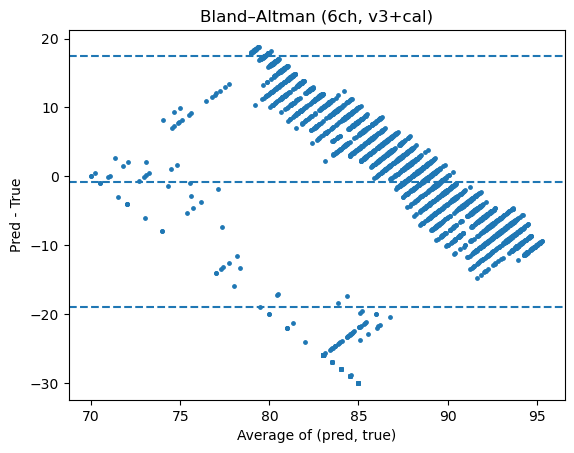

In [35]:
# === Self-contained: Model LOSO(with calibration) training evaluation ===
import numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix
import matplotlib.pyplot as plt

# 1) model
class Shallow1DCNN(nn.Module):
    def __init__(self, in_ch=6):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv1d(in_ch, 32, 7, padding=3), nn.ReLU(inplace=True),
            nn.Conv1d(32, 64, 5, padding=2),    nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1),
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(64, 1))
    def forward(self, x):  # x:(B,C,T)
        return self.head(self.feat(x)).squeeze(1)

# 2) LOSO + Linear calibration per fold（a·pred+b）
def run_loso_with_calibration(X, y, owners, model_factory,
                              epochs=160, base_lr=3e-4, wd=5e-4, bs=256, patience=25,
                              low_weight=5.0, seed=42, clamp=(70.0, 100.0)):
    device = "cuda" if torch.cuda.is_available() else ("mps" if hasattr(torch.backends,'mps') and torch.backends.mps.is_available() else "cpu")
    print("device:", device)
    rng = np.random.default_rng(seed)

    X_t = torch.from_numpy(X).float()
    y_t = torch.from_numpy(y).float().unsqueeze(1)
    subjects = np.unique(owners)

    y_true_all, y_pred_all, per = [], [], []
    for held in subjects:
        te = np.where(owners==held)[0]
        tr = np.where(owners!=held)[0]
        rng.shuffle(tr); n_val = max(1, int(len(tr)*0.1))
        va, tr = tr[:n_val], tr[n_val:]

        # Hypoxia-weighted
        w = torch.ones(len(tr))
        w[(y_t[tr].squeeze(1) < 90).cpu()] = low_weight
        sampler = WeightedRandomSampler(weights=w, num_samples=len(w), replacement=True)

        model = model_factory(X.shape[1]).to(device)
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        opt = torch.optim.AdamW(model.parameters(), lr=base_lr, weight_decay=wd)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
        loss = nn.SmoothL1Loss()

        best_mae, wait = 1e9, patience
        # train
        for ep in range(epochs):
            model.train()
            dl = DataLoader(TensorDataset(X_t[tr], y_t[tr]), batch_size=bs, sampler=sampler, drop_last=False)
            for xb, yb in dl:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad(); pred = model(xb); l = loss(pred, yb.squeeze(1)); l.backward(); opt.step()
            sch.step()
            # verification
            model.eval()
            with torch.no_grad():
                dlv = DataLoader(TensorDataset(X_t[va], y_t[va]), batch_size=bs, shuffle=False)
                pv, gv = [], []
                for xb, yb in dlv:
                    pv.append(model(xb.to(device)).cpu().numpy()); gv.append(yb.numpy())
                pv = np.concatenate(pv).squeeze(); gv = np.concatenate(gv).squeeze()
                mae_va = float(mean_absolute_error(gv, pv))
            if mae_va < best_mae - 1e-4:
                best_mae = mae_va
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                wait = patience
            else:
                wait -= 1
                if wait <= 0: break

        # Calibration: Fit y ≈ a·pred b on (train val)
        model.load_state_dict(best_state); model.eval()
        with torch.no_grad():
            dl_cal = DataLoader(TensorDataset(torch.cat([X_t[tr], X_t[va]],0),
                                              torch.cat([y_t[tr], y_t[va]],0)),
                                batch_size=bs, shuffle=False)
            p_cal, g_cal = [], []
            for xb, yb in dl_cal:
                p_cal.append(model(xb.to(device)).cpu().numpy()); g_cal.append(yb.numpy())
        p_cal = np.concatenate(p_cal).squeeze(); g_cal = np.concatenate(g_cal).squeeze()
        A = np.vstack([p_cal, np.ones_like(p_cal)]).T
        a, b = np.linalg.lstsq(A, g_cal, rcond=None)[0]

        # Test and apply calibration
        with torch.no_grad():
            dlt = DataLoader(TensorDataset(X_t[te], y_t[te]), batch_size=bs, shuffle=False)
            pt = [model(xb.to(device)).cpu().numpy() for xb,_ in dlt]
        pt = np.concatenate(pt).squeeze()
        pt = a*pt + b
        if clamp is not None:
            pt = np.clip(pt, clamp[0], clamp[1])

        gt = y_t[te].numpy().squeeze()
        fold_mae = float(mean_absolute_error(gt, pt))
        print(f"[LOSO+cal] held={int(held)}  test MAE={fold_mae:.3f}%  n={len(te)}   (a={a:.3f}, b={b:.3f})")
        y_true_all.append(gt); y_pred_all.append(pt); per.append({"subject": int(held), "mae": fold_mae, "n": int(len(te)), "a": float(a), "b": float(b)})

    return np.concatenate(y_true_all), np.concatenate(y_pred_all), per

# 3) train
y_true_v3, y_pred_v3, per_v3 = run_loso_with_calibration(
    X6_v3, y3, own3,
    model_factory=lambda in_ch: Shallow1DCNN(in_ch),
    epochs=160, base_lr=3e-4, wd=5e-4, bs=256, patience=25, low_weight=8.0
)
print("LOSO mean MAE (v3+cal) =", np.mean([r['mae'] for r in per_v3]))

# 4) Basic Assessment (Main Indicators of the paper
yt, yp = y_true_v3, y_pred_v3
mae  = float(mean_absolute_error(yt, yp))
rmse = float(np.sqrt(np.mean((yt-yp)**2)))
r2   = float(r2_score(yt, yp))
print(f"MAE={mae:.3f}%  RMSE(Arms)={rmse:.3f}%  R2={r2:.3f}")
for lo, hi in [(70,80),(80,90),(90,100)]:
    m = (yt>=lo)&(yt<=hi)
    if m.any():
        print(f"MAE {lo}-{hi}% =", float(mean_absolute_error(yt[m], yp[m])), f"(n={m.sum()})")

def sens_spec(y_true, y_pred, thr):
    yb = (y_true < thr).astype(int); pb = (y_pred < thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(yb, pb, labels=[0,1]).ravel()
    return tp/(tp+fn+1e-8), tn/(tn+fp+1e-8), int(tp+fn), int(tn+fp)

for thr in [92.0, 90.0, 88.0]:
    s, p, pos_n, neg_n = sens_spec(yt, yp, thr)
    print(f"Thr<{thr:.0f}%  Sens={s:.3f}  Spec={p:.3f}  (pos={pos_n}, neg={neg_n})")

# Bland–Altman
diff = yp - yt; avg = 0.5*(yp + yt)
md, sd = diff.mean(), diff.std()
plt.figure(); plt.scatter(avg, diff, s=6)
plt.axhline(md, ls='--'); plt.axhline(md+1.96*sd, ls='--'); plt.axhline(md-1.96*sd, ls='--')
plt.xlabel("Average of (pred, true)"); plt.ylabel("Pred - True"); plt.title("Bland–Altman (6ch, v3+cal)"); plt.show()


In [36]:
# Select the hand with a higher SNR (larger AC/DC) as the sample for that second. It can also be used if only one hand passes the quality control.

import numpy as np
from scipy import signal
from scipy.signal import medfilt

def _acdc_score(win):
    ac = np.percentile(win, 95, axis=1) - np.percentile(win, 5, axis=1)
    dc = np.maximum(win.mean(axis=1), 1e-6)
    return float((ac/dc).max())

def make_besthand_windows_filtered_v3(
    data, groundtruth, device_idx=0, fps=30, win=90, band=(0.5,8.0),
    mean_frac_thr=0.20, per_ch_std_thr=1e-3, acdc_thr=0.015, order=3, med_k=5
):
    L, R = slice(0,3), slice(3,6)
    b, a = signal.butter(order, [band[0]/(fps/2), band[1]/(fps/2)], btype="band")
    n_subj, _, n_frames = data.shape
    n_secs = groundtruth.shape[-1]

    subj_mean_L = np.stack([np.nanmean(data[i, L, :], axis=1) for i in range(n_subj)])
    subj_mean_R = np.stack([np.nanmean(data[i, R, :], axis=1) for i in range(n_subj)])

    Xs, ys, owners = [], [], []
    for pid in range(n_subj):
        baseL = np.maximum(subj_mean_L[pid], 1e-6)
        baseR = np.maximum(subj_mean_R[pid], 1e-6)
        for sec in range(1, n_secs-1):
            c = sec*fps; s, e = c - win//2, c + win//2
            if s < 0 or e > n_frames: continue
            y = float(groundtruth[pid, device_idx, sec])
            if not (70.0 <= y <= 100.0): continue

            xL = data[pid, L, s:e]; xR = data[pid, R, s:e]
            if xL.shape[-1] != win or xR.shape[-1] != win: continue

            def ok(x, base):
                return (np.all(x.mean(axis=1) >= mean_frac_thr*base) and
                        np.all(x.std(axis=1) >= per_ch_std_thr) and
                        _acdc_score(x) >= acdc_thr)

            okL, okR = ok(xL, baseL), ok(xR, baseR)
            if not (okL or okR):  # Neither of the two hands can pass
                continue

            # 选 SNR 更高的一只
            pick = xL if (okL and (not okR or _acdc_score(xL) >= _acdc_score(xR))) else xR

            # 带通 + 中值 + z-score
            xf = np.zeros_like(pick, dtype=np.float32)
            for k in range(pick.shape[0]):
                tmp = signal.filtfilt(b, a, pick[k], method="pad")
                tmp = medfilt(tmp, kernel_size=med_k)
                m, sd = tmp.mean(), tmp.std() + 1e-8
                xf[k] = (tmp - m) / sd

            Xs.append(xf.astype(np.float32)); ys.append(y); owners.append(pid)

    X3 = np.stack(Xs).astype(np.float32)
    y  = np.array(ys, np.float32)
    own= np.array(owners, int)
    print("[besthand v3] X3:", X3.shape, "y:", y.shape, "subjects:", np.unique(own))
    return X3, y, own

# Generate the optimal hand sample (set acdc_thr to 0.015 to ensure sufficient sample size; it can be adjusted between 0.015 and 0.025)

X3_best, y_best, own_best = make_besthand_windows_filtered_v3(
    data, groundtruth, device_idx=DEVICE_IDX, acdc_thr=0.015
)

from collections import Counter
print("per-subject counts (besthand):", Counter(own_best.tolist()))


[besthand v3] X3: (5457, 3, 90) y: (5457,) subjects: [0 1 2 3 4 5]
per-subject counts (besthand): Counter({1: 1119, 2: 1026, 3: 1013, 4: 855, 0: 724, 5: 720})


device: mps
[LOSO+cal] held=0  test MAE=16.247%  n=724   (a=0.916, b=8.178)
[LOSO+cal] held=1  test MAE=5.758%  n=1119   (a=0.483, b=47.650)
[LOSO+cal] held=2  test MAE=6.902%  n=1026   (a=0.516, b=44.905)
[LOSO+cal] held=3  test MAE=5.058%  n=1013   (a=0.776, b=22.976)
[LOSO+cal] held=4  test MAE=6.440%  n=855   (a=0.604, b=37.537)
[LOSO+cal] held=5  test MAE=7.170%  n=720   (a=0.352, b=58.767)
LOSO mean MAE (besthand+cal) = 7.929188807805379
MAE=7.528%  RMSE=9.753%  R2=-0.433
Thr<92%  Sens=0.991  Spec=0.039
Thr<90%  Sens=0.884  Spec=0.283
Thr<88%  Sens=0.564  Spec=0.632


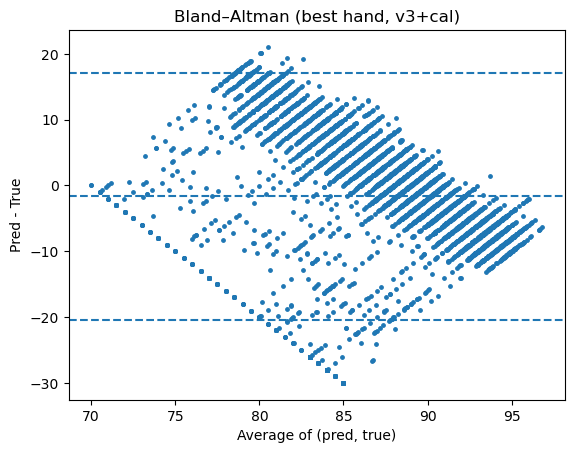

In [37]:
# Use the same set of training functions, but in_ch=3
y_true_best, y_pred_best, per_best = run_loso_with_calibration(
    X3_best, y_best, own_best,
    model_factory=lambda in_ch: Shallow1DCNN(in_ch),  # 3通道输入
    epochs=180, base_lr=3e-4, wd=5e-4, bs=256, patience=25, low_weight=8.0
)
print("LOSO mean MAE (besthand+cal) =", np.mean([r['mae'] for r in per_best]))

# Evaluation
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix
import numpy as np, matplotlib.pyplot as plt

yt, yp = y_true_best, y_pred_best
print(f"MAE={mean_absolute_error(yt, yp):.3f}%  RMSE={np.sqrt(np.mean((yt-yp)**2)):.3f}%  R2={r2_score(yt, yp):.3f}")
for thr in [92.0, 90.0, 88.0]:
    yb = (yt < thr).astype(int); pb = (yp < thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(yb, pb, labels=[0,1]).ravel()
    sens = tp/(tp+fn+1e-8); spec = tn/(tn+fp+1e-8)
    print(f"Thr<{thr:.0f}%  Sens={sens:.3f}  Spec={spec:.3f}")

diff = yp - yt; avg = 0.5*(yp + yt)
md, sd = diff.mean(), diff.std()
plt.figure(); plt.scatter(avg, diff, s=6)
plt.axhline(md, ls='--'); plt.axhline(md+1.96*sd, ls='--'); plt.axhline(md-1.96*sd, ls='--')
plt.xlabel("Average of (pred, true)"); plt.ylabel("Pred - True"); plt.title("Bland–Altman (best hand, v3+cal)"); plt.show()
